Tickets KOKOCUP

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx

In [2]:
# Desactivar advertencias
warnings.filterwarnings("ignore")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 📌 Análisis de tickets de compra y reglas de asociación

Este código realiza un análisis de los tickets de compra, utilizando Apriori y FP-Growth para encontrar reglas de asociación y correlaciones entre productos. Además, genera visualizaciones para facilitar la interpretación de los datos.

## 🔹 1. Cargar y limpiar los datos

In [3]:
#Leer el csv guardado anteriormente
#from google.colab import drive
#drive.mount('/content/drive/')

In [4]:
#df=pd.read_csv('/content/drive/MyDrive/kokocup/ventas_tickets.csv')

In [5]:
#Leer desde la PC
from google.colab import files
uploaded = files.upload()

Saving market_basket_cleaned.csv to market_basket_cleaned (1).csv


In [6]:
df = pd.read_csv('market_basket_cleaned.csv', sep = ',')

In [7]:
df.head()

,idventa,Producto,Categoria,Cantidad
0,71437,HUEVO REVUELTO C/ PANCETA,DESAYUNOS,1
1,71437,HUEVO REVUELTO C/ PANCETA,DESAYUNOS,1
2,71437,MIXTO JAMON Y QUESO,DESAYUNOS,1
3,71437,CAFE IRLANDES,BEBIDAS,1
4,71437,CAFE IRLANDES,BEBIDAS,1


In [8]:
# Limpiar el DataFrame
# Renombrar columnas si es necesario
df.columns = df.columns.str.strip()

In [9]:
df.head()

,idventa,Producto,Categoria,Cantidad
0,71437,HUEVO REVUELTO C/ PANCETA,DESAYUNOS,1
1,71437,HUEVO REVUELTO C/ PANCETA,DESAYUNOS,1
2,71437,MIXTO JAMON Y QUESO,DESAYUNOS,1
3,71437,CAFE IRLANDES,BEBIDAS,1
4,71437,CAFE IRLANDES,BEBIDAS,1


In [10]:
# Eliminar filas con valores nulos en columnas esenciales
df.dropna(subset=['idventa', 'Producto', 'Categoria', 'Cantidad'], inplace=True)

In [11]:
# Excluir la categoría 'Delivery' del análisis
df = df[df['Categoria'].str.strip().str.lower() != 'delivery']

In [12]:
# Asegurar que 'Cantidad' es un número entero
df['Cantidad'] = df['Cantidad'].astype(int)

## 🔹 2. Preparación de datos para Market Basket Analysis


In [13]:
# Agrupar productos por cada transacción para tener las combinaciones completas
transactions = df.groupby('idventa')['Producto'].apply(list)

# Transformar los datos en formato binario para Market Basket Analysis
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_sets = pd.DataFrame(te_ary, columns=te.columns_)
# Convertir valores True/False en 1/0 para Apriori
basket_sets = basket_sets.astype(int)


In [14]:
print(basket_sets.stack().value_counts())


0    52852
1      612
Name: count, dtype: int64


In [15]:
df.groupby("idventa")["Producto"].nunique().describe()


,Producto
count,328.000000
mean,1.865854
std,1.206630
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000


## 🔹 3. Aplicación de Apriori y FP-Growth


In [16]:
# Ajustar el mínimo soporte para encontrar más reglas
min_support = 0.005  # Reducido para detectar más combinaciones

In [17]:
# Aplicar el algoritmo Apriori para encontrar conjuntos de artículos frecuentes
frequent_itemsets = apriori(basket_sets, min_support=min_support, use_colnames=True)
frequent_itemsets


,support,itemsets
0,0.012195,(ACAI DE 700ML P)
1,0.006098,(ACAI DE TRES LECHES VASO 500ML)
2,0.021341,(AGUA MINERAL 500ML)
3,0.006098,(AGUA TONICA BOTELLA)
4,0.009146,(ALFAJOR (G))
...,...,...
152,0.006098,"(TOPPING GRANOLA, TOPPING BANANA, ACAI DE 700M..."
153,0.006098,"(TOPPING LECHE EN POLVO, TOPPING BANANA, ACAI ..."
154,0.009146,"(TOPPING GRANOLA, TOPPING LECHE EN POLVO, ACAI..."
155,0.006098,"(TOPPING GRANOLA, TOPPING LECHE EN POLVO, TOPP..."


In [18]:
# Aplicar el algoritmo FP-Growth (más eficiente para bases de datos dispersas)
frequent_itemsets_fpgrowth = fpgrowth(basket_sets, min_support=min_support, use_colnames=True)

In [19]:
# Verificar si hay combinaciones de más de un producto
multi_itemsets = frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth['itemsets'].apply(lambda x: len(x) > 1)]
print("Itemsets con más de un producto:")
print(multi_itemsets.head())

Itemsets con más de un producto:
      support                                           itemsets
104  0.006098               (JUGO DE 400ML, MIXTO JAMON Y QUESO)
105  0.006098  (SANDWICH CALIENTE POLLO Y CATUPRY, JUGO DE 40...
106  0.006098  (SANDWICH CALIENTE POLLO Y CATUPRY, SANDWICH C...
107  0.006098                 (JUGO DE 400ML, SANDWICH CALIENTE)
108  0.012195               (MANDIO CHYRYRY, TORTILLA 8UNIDADES)


## 🔹 4. Generación de reglas de asociación

In [20]:
# Generar reglas de asociación con FP-Growth con umbrales más bajos
rules_fp = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.2)
rules_filtered_fp = rules_fp[(rules_fp['lift'] >= 1.2)]

In [21]:
# Verificar cantidad de reglas generadas
print("Cantidad de reglas generadas:", len(rules_filtered_fp))

Cantidad de reglas generadas: 105


In [22]:
# Crear un DataFrame con las reglas en formato estructurado
rules_df = pd.DataFrame({
    'Si Compro': rules_filtered_fp['antecedents'].apply(lambda x: ', '.join(list(x))),
    'Comprara': rules_filtered_fp['consequents'].apply(lambda x: ', '.join(list(x))),
    'Confianza': rules_filtered_fp['confidence'],
    'Lift': rules_filtered_fp['lift']
})

In [31]:
rules_df.head()

,Si Compro,Comprara,Confianza,Lift
0,SANDWICH CALIENTE POLLO Y CATUPRY,JUGO DE 400ML,0.200000,5.466667
1,SANDWICH CALIENTE POLLO Y CATUPRY,SANDWICH CALIENTE,0.200000,7.288889
2,SANDWICH CALIENTE,SANDWICH CALIENTE POLLO Y CATUPRY,0.222222,7.288889
3,SANDWICH CALIENTE,JUGO DE 400ML,0.222222,6.074074
4,MANDIO CHYRYRY,TORTILLA 8UNIDADES,0.571429,23.428571


In [33]:
rules_df

,Si Compro,Comprara,Confianza,Lift
0,SANDWICH CALIENTE POLLO Y CATUPRY,JUGO DE 400ML,0.200000,5.466667
1,SANDWICH CALIENTE POLLO Y CATUPRY,SANDWICH CALIENTE,0.200000,7.288889
2,SANDWICH CALIENTE,SANDWICH CALIENTE POLLO Y CATUPRY,0.222222,7.288889
3,SANDWICH CALIENTE,JUGO DE 400ML,0.222222,6.074074
4,MANDIO CHYRYRY,TORTILLA 8UNIDADES,0.571429,23.428571
...,...,...,...,...
100,JUGO 1L,MIXTO JAMON Y QUESO,0.333333,8.410256
101,DESCUENTO,SANDWICH CALIENTE DE POLLO Y QUESO CATUPIRY (P),0.222222,36.444444
102,SANDWICH CALIENTE DE POLLO Y QUESO CATUPIRY (P),DESCUENTO,1.000000,36.444444
103,JUGO DURAZNO CHICO,MIXTO JAMON Y QUESO,0.666667,16.820513


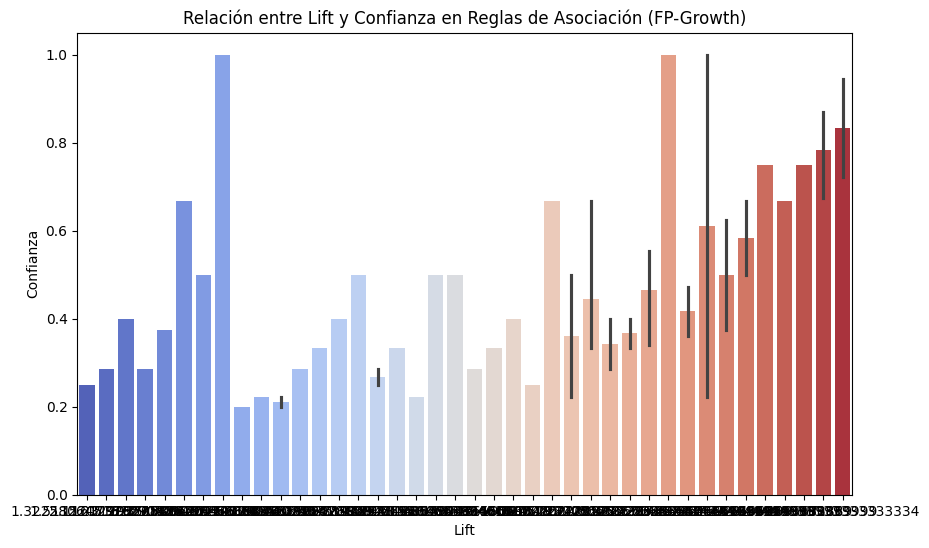


Análisis completado. Se han generado reglas de asociación con FP-Growth y análisis de afinidad de productos. Los resultados han sido exportados.


In [23]:
# Visualización de los resultados con FP-Growth
if not rules_filtered_fp.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=rules_filtered_fp['lift'], y=rules_filtered_fp['confidence'], palette='coolwarm')
    plt.xlabel("Lift")
    plt.ylabel("Confianza")
    plt.title("Relación entre Lift y Confianza en Reglas de Asociación (FP-Growth)")
    plt.show()
else:
    print("No hay reglas de asociación significativas para visualizar con FP-Growth.")

print("\nAnálisis completado. Se han generado reglas de asociación con FP-Growth y análisis de afinidad de productos. Los resultados han sido exportados.")


In [24]:
#Si la mayoría de las transacciones tienen productos únicos, el modelo no puede generar reglas.
print(df.groupby("idventa")["Producto"].nunique().describe())


count    328.000000
mean       1.865854
std        1.206630
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        8.000000
Name: Producto, dtype: float64


### 🔍 Conclusión sobre la distribución de combinaciones de productos

A partir del análisis de la distribución de productos por transacción, se pueden extraer las siguientes conclusiones:

1️⃣ **El 50% de las transacciones contienen solo un producto**  
   - Esto implica que la mitad de las ventas **no generan combinaciones** para la identificación de reglas de asociación.  
   - **Impacto**: Estas transacciones no aportan información útil para el análisis de cesta de mercado, ya que no hay una relación entre productos.

2️⃣ **El 75% de las transacciones tienen 2 o menos productos**  
   - La mayoría de las compras incluyen una cantidad muy baja de productos, lo que **limita las combinaciones posibles**.  
   - **Impacto**: Es probable que las reglas de asociación sean escasas o tengan una baja confianza, ya que no hay suficiente repetición de combinaciones en los datos.

3️⃣ **La transacción con más productos tiene 8**  
   - Solo un pequeño grupo de transacciones contiene múltiples productos, lo que **reduce la cantidad de asociaciones detectables**.  
   - **Impacto**: Las reglas de asociación se formarán principalmente dentro de este subconjunto, lo que puede generar un sesgo hacia combinaciones menos representativas en el total de las ventas.

➡️ **Recomendación**: Dado este escenario, se pueden probar alternativas como **reducir los umbrales de soporte y confianza** en los modelos de asociación, aplicar **métodos de agrupación** o explorar **correlaciones entre productos en lugar de reglas de asociación estándar**.


## 🔹 5. Análisis de combinaciones más frecuentes de productos

In [25]:
# Análisis de combinaciones más frecuentes de productos
top_combinations = df.groupby("idventa")["Producto"].apply(lambda x: tuple(sorted(x))).value_counts()
top_combinations.to_csv('top_combinaciones.csv')
print("\nTop 10 combinaciones de productos más frecuentes:")
print(top_combinations.head(10))



Top 10 combinaciones de productos más frecuentes:
Producto
(CAMADINHA DE ACAI 300ML,)                                                     19
(CAMADINHA DE ACAI 300ML, CAMADINHA DE ACAI 300ML)                             18
(CAMADINHA DE ACAI 400ML,)                                                     16
(CAMADINHA DE ACAI 500ML,)                                                      7
(MENU DEL DIA,)                                                                 6
(CAMADINHA DE ACAI 400ML, CAMADINHA DE ACAI 400ML)                              5
(CAMADINHA DE ACAI 500ML, CAMADINHA DE ACAI 500ML)                              5
(MENU DEL DIA, MENU DEL DIA)                                                    4
(CAMADINHA DE ACAI 300ML, CAMADINHA DE ACAI 300ML, CAMADINHA DE ACAI 300ML)     4
(ENSALADA DE FRUTAS CON CHANTILLY,)                                             4
Name: count, dtype: int64


## 🔹 6. Análisis de correlación entre productos y visualización con gráfico de red


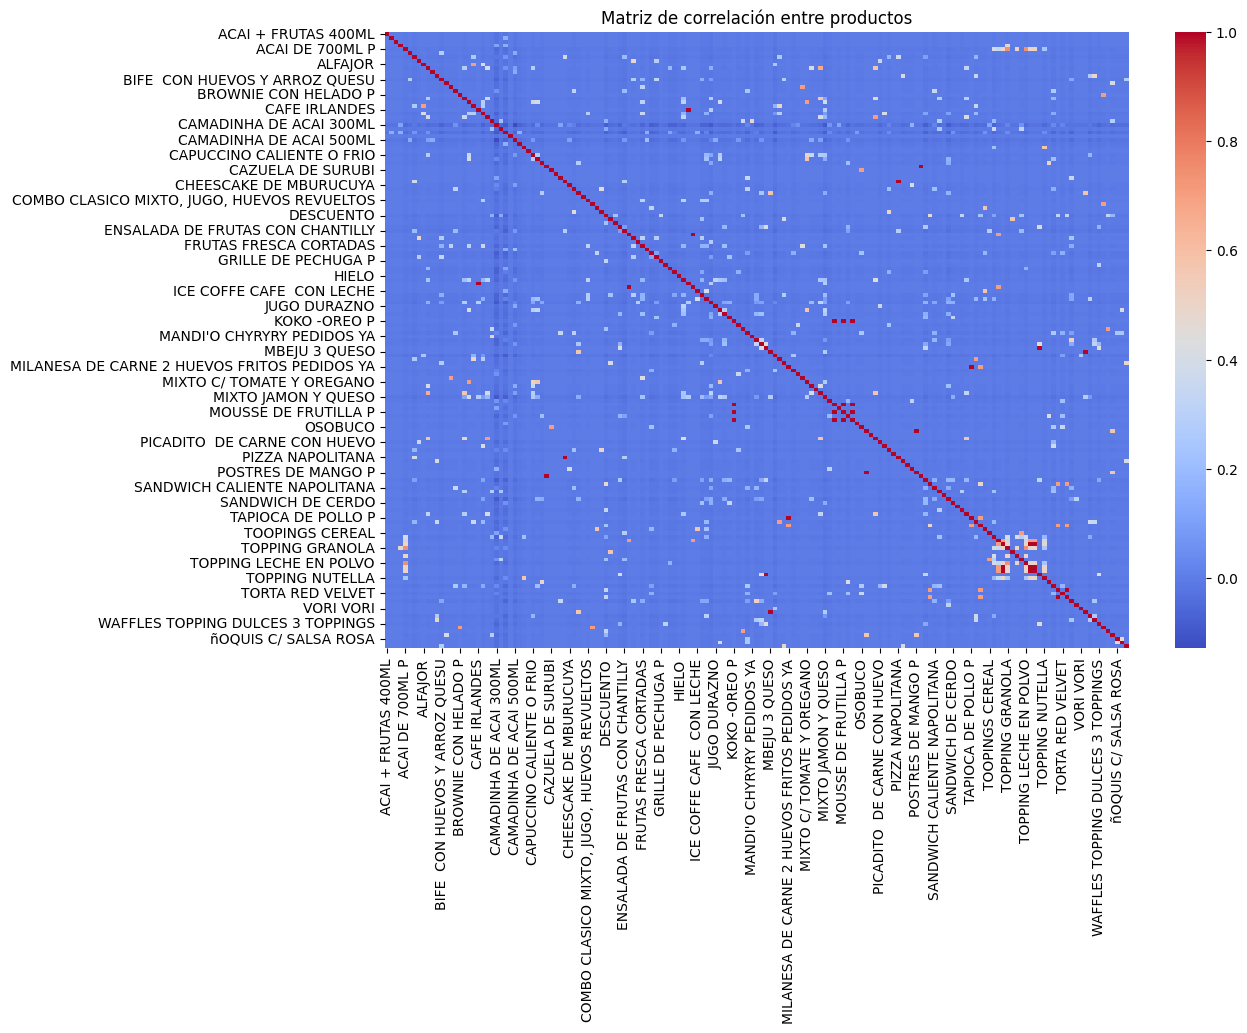

In [26]:
# Análisis de correlación entre productos
correlation_matrix = basket_sets.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Matriz de correlación entre productos")
plt.show()

In [27]:
# Explicación del significado de las correlaciones
print("\nLas correlaciones representan la relación entre productos que suelen comprarse juntos. Un valor alto indica que los productos tienen una fuerte conexión en las compras, lo que sugiere oportunidades para promociones y estrategias de venta cruzada.")



Las correlaciones representan la relación entre productos que suelen comprarse juntos. Un valor alto indica que los productos tienen una fuerte conexión en las compras, lo que sugiere oportunidades para promociones y estrategias de venta cruzada.



Las correlaciones representan la relación entre productos que suelen comprarse juntos. Un valor alto indica que los productos tienen una fuerte conexión en las compras, lo que sugiere oportunidades para promociones y estrategias de venta cruzada.


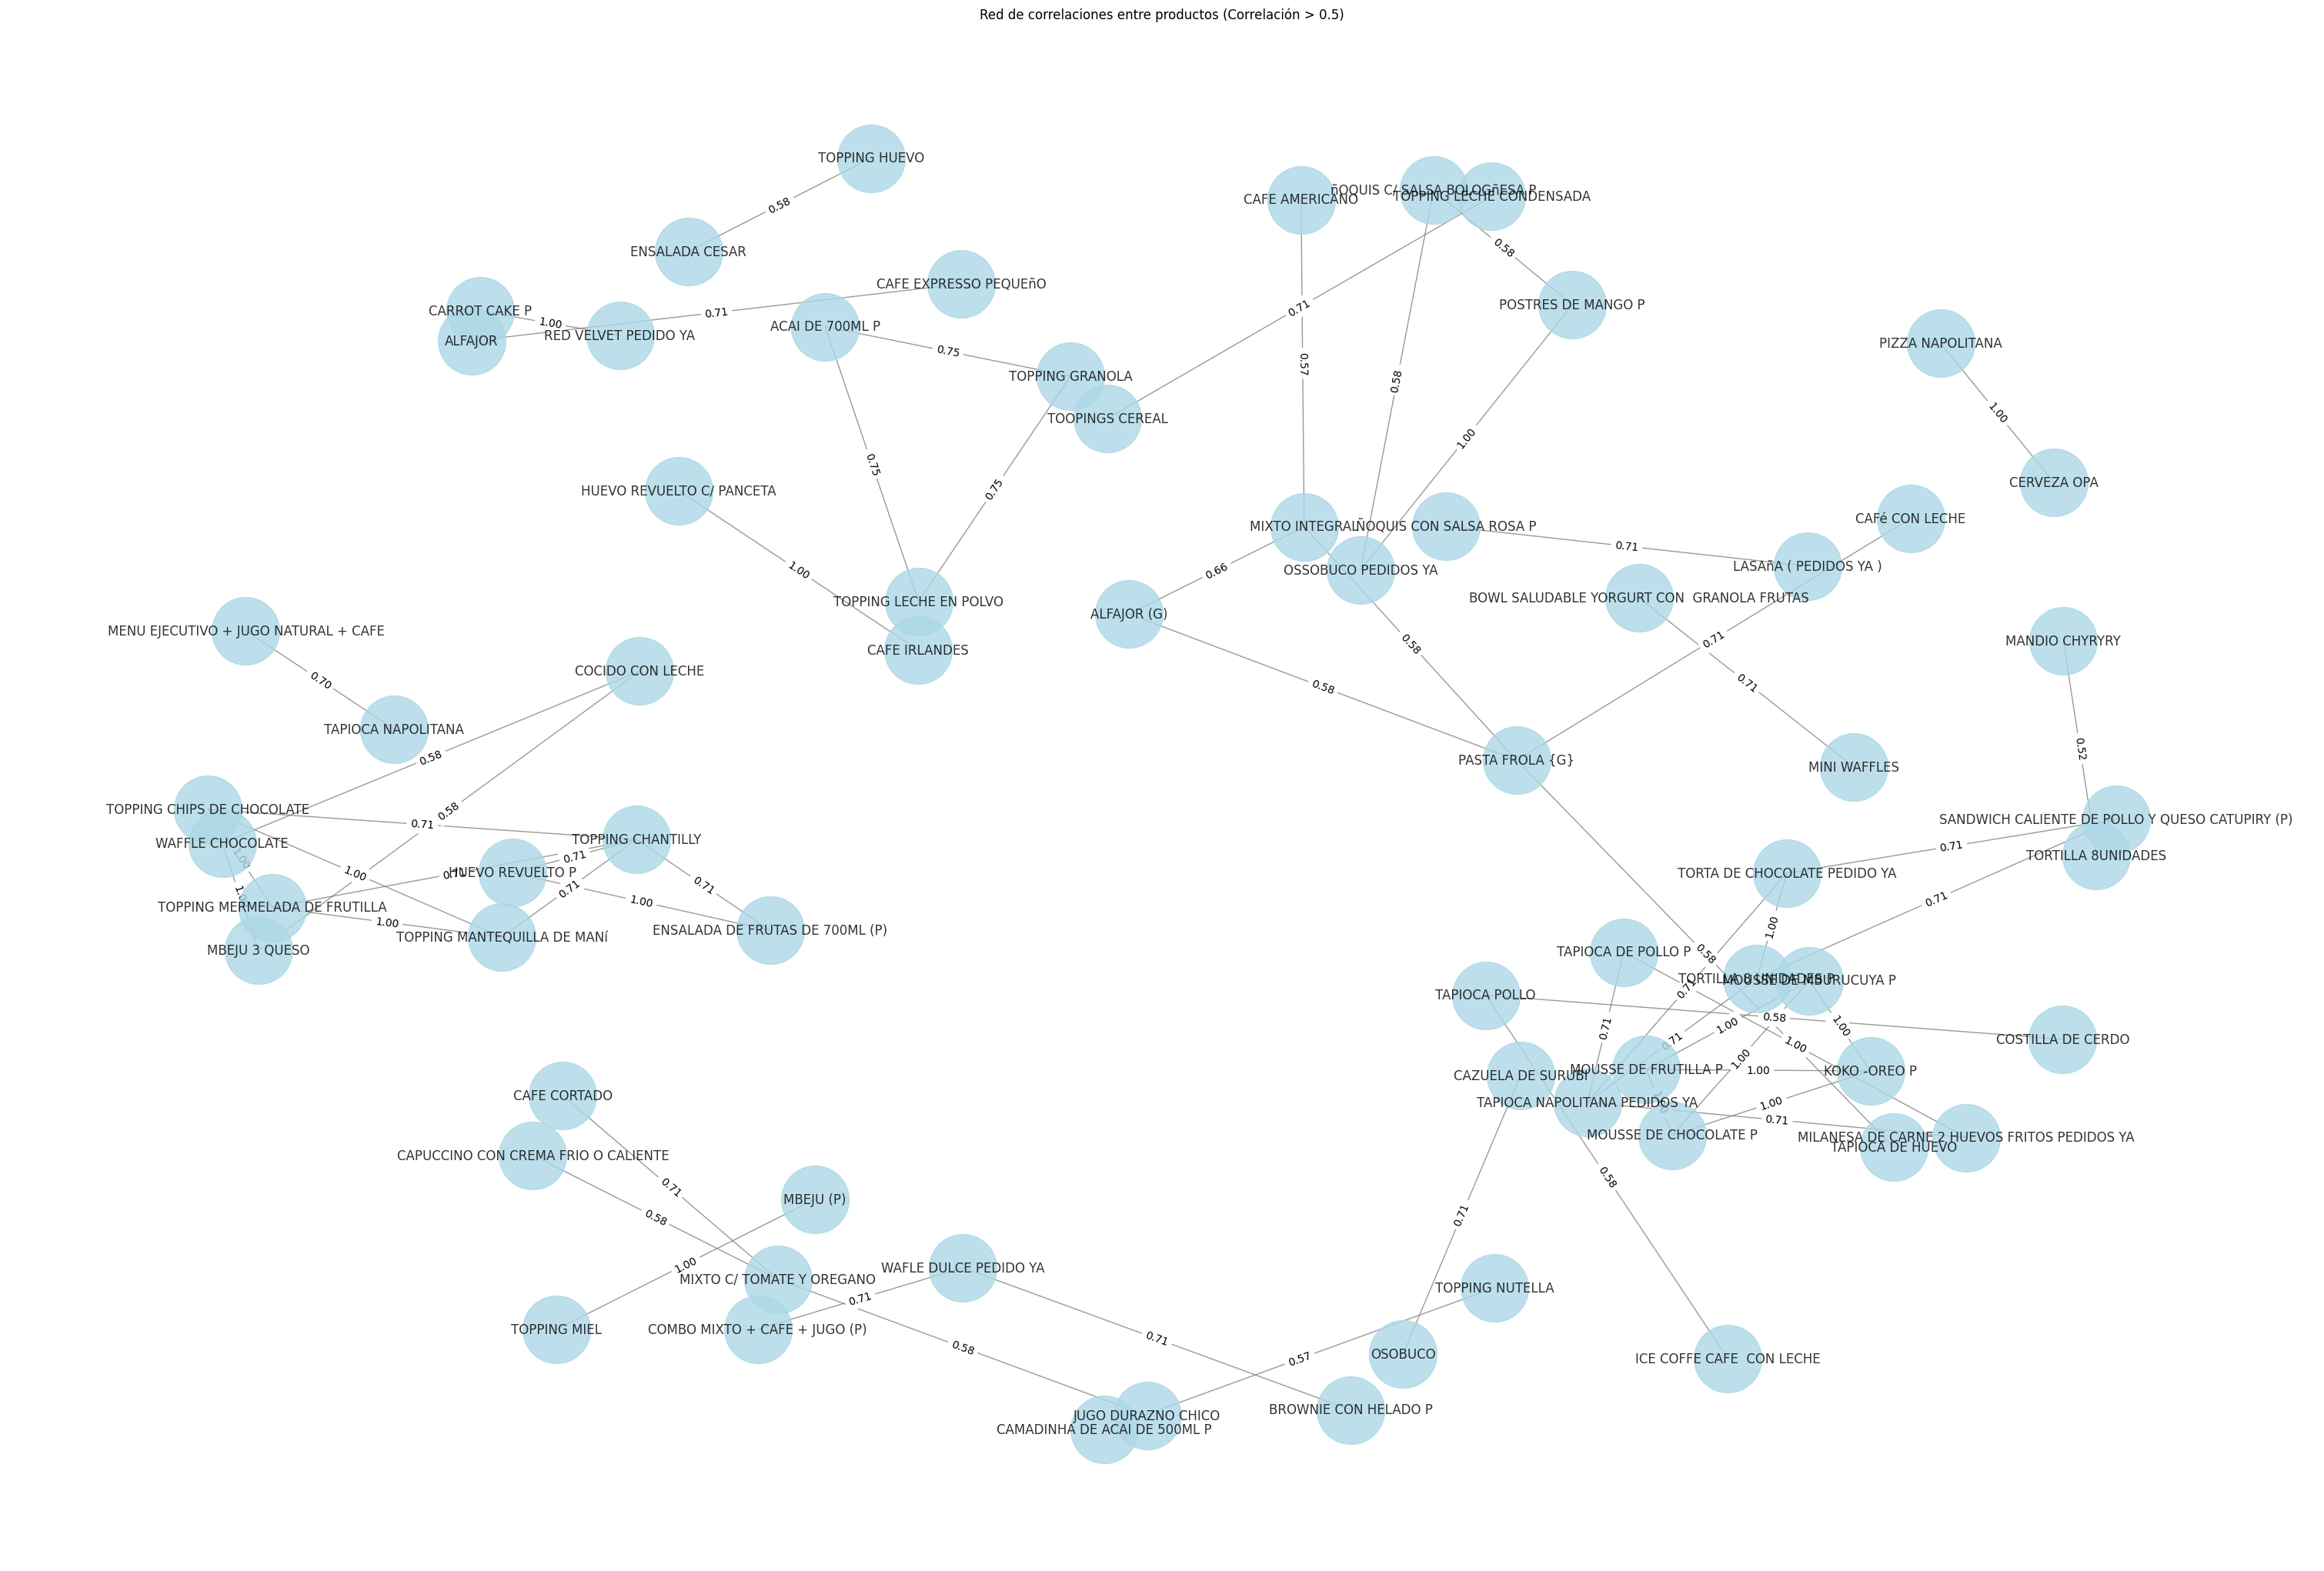

In [28]:
# Análisis de correlación entre productos con filtrado de correlaciones altas y visualización con un gráfico de red
correlation_matrix = basket_sets.corr()
high_corr_pairs = correlation_matrix.stack().reset_index()
high_corr_pairs.columns = ['Si Compro', 'Comprara', 'Correlación']
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Correlación'] > 0.5) & (high_corr_pairs['Si Compro'] != high_corr_pairs['Comprara'])]

# Explicación del significado de las correlaciones
print("\nLas correlaciones representan la relación entre productos que suelen comprarse juntos. Un valor alto indica que los productos tienen una fuerte conexión en las compras, lo que sugiere oportunidades para promociones y estrategias de venta cruzada.")

# Ajustar la visualización del gráfico de red para mayor claridad
G = nx.Graph()
for index, row in high_corr_pairs.iterrows():
    G.add_edge(row['Si Compro'], row['Comprara'], weight=row['Correlación'])

plt.figure(figsize=(30, 20))  # Aumentar el tamaño del gráfico
pos = nx.spring_layout(G, k=0.5, seed=42)  # Ajustar distancia entre nodos
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=4000, font_size=12, alpha=0.8)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(row['Si Compro'], row['Comprara']): f"{row['Correlación']:.2f}" for _, row in high_corr_pairs.iterrows()}, font_size=10)
plt.title("Red de correlaciones entre productos (Correlación > 0.5)")
plt.show()

In [34]:
# Crear un DataFrame con las correlaciones en formato estructurado
correlation_df = high_corr_pairs[['Si Compro', 'Comprara', 'Correlación']]
correlation_df.to_csv('correlaciones_estructuradas.csv', index=False)


In [30]:
correlation_df.head(10)

,Si Compro,Comprara,Correlación
788,ACAI DE 700ML P,TOPPING GRANOLA,0.746914
792,ACAI DE 700ML P,TOPPING LECHE EN POLVO,0.746914
1323,ALFAJOR,CAFE EXPRESSO PEQUEñO,0.706025
1562,ALFAJOR (G),MIXTO INTEGRAL,0.663590
1574,ALFAJOR (G),PASTA FROLA {G},0.575582
2373,BOWL SALUDABLE YORGURT CON GRANOLA FRUTAS,MINI WAFFLES,0.706025
2765,BROWNIE CON HELADO P,WAFLE DULCE PEDIDO YA,0.706025
2866,CAFE AMERICANO,MIXTO INTEGRAL,0.572903
3026,CAFE CORTADO,MIXTO C/ TOMATE Y OREGANO,0.706025
3105,CAFE EXPRESSO PEQUEñO,ALFAJOR,0.706025


# 📌 **Conclusión:**
Se han generado reglas de asociación estructuradas, análisis de combinaciones y correlaciones de productos en un gráfico de red con mejor distribución. Además, las correlaciones han sido exportadas en 'correlaciones_estructuradas.csv'.
